Herein, we study the effect of reservior size and spectral radius on the accuracy of image segmentation using the standard ESN model. 

In [1]:
from glob import glob
from esn_classifier import ESNClassifier
from esn_svm import ESNSVM
from util import *
import pickle as pk
import pandas as pd
from sklearn import svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import svm

## Data Preprocessing
First, we retrieve the image datasets from their respective csv files (saved in `data/raw`) and combine them into one dataset. Next, we preprocess the resulting data by shuffling it and normalizing the feature matrix using `MinMax`. The result is saved as *data.csv* in `data/preprocessed`. 

**NB:** It is only necessary to rerun the code in this step if the raw image datasets are updated or changed.

In [2]:
# # Retrieve all files with extension .csv in subfolder raw
# files = glob('..\\data\\raw\\*.csv')
# # Combine the image datasets into one dataset
# ds  = combine_datasets(files)
# # Shuffle the combined dataset, normalize the feature set and save the result
# transform_save(ds, 'data','..\\data\\processed')

## ESN Classifier Configuration
Here, we specify the inputs of the ESN Classifier. This includes the hyperparameters of the reservoir and readout and other required inputs such as the trainsient length $trans_len$, where the transient is $[0, trans \_ len )$. We save these inputs a data dictionary called `esn_config`. 

In [3]:
esn_config = {}
esn_config['data'] =\
    '..\\data\\processed\\data.csv'             # data file path + name
esn_config['result_loc'] = 'models\\'            # where to save outputs  
esn_config['in_size'] = 15                      # number of input units of the
                                                # the ESN reservoir
esn_config['out_size'] = 1                      # number of output units
esn_config['trans_len'] = 200                   # transient length

# =========== Reservoir RNN global parameters ==============

# range of reservoir sizes
# esn_config['res_size'] =\
#     np.array([700, 800, 900, 1000], dtype =int)    
esn_config['res_size'] = 100 
esn_config['lr'] = 0.3                          # leaking rate
# range of spectral radius
esn_config['spec_rad'] = 0.01  
# esn_config['spec_rad'] =\
#     np.array([0.01,0.03, 0.05, 0.099], dtype =float)                 
                                                
esn_config['init_scale'] = 0.5                  # weight matrix scaling value

# =========== Readout parameters =================
# create an svm classification model
esn_config['svm_model'] = svm.SVC(kernel='rbf', C=1.0, gamma=1000)                

print (f'ESN Classifier Configuration \n {esn_config}')

ESN Classifier Configuration 
 {'data': '..\\data\\processed\\data.csv', 'result_loc': 'models\\', 'in_size': 15, 'out_size': 1, 'trans_len': 200, 'res_size': 100, 'lr': 0.3, 'spec_rad': 0.01, 'init_scale': 0.5, 'svm_model': SVC(gamma=1000)}


## Training and Testing Dataset
Now, we load the preprocessed dataset. It is represented by a 2-dimensional array with shape `[n_rows, n_cols]`, where *n_rows* is the number of data and *n_cols* is the number of variables. Next, we split the data into $80 \%$ training set and $20\%$ test set. We denote the feature matrices of the training and test sets by `X_train` and `X_test`, respectively. The corresponding response vectors are denoted by `Y_train` and `Y_test`, respectively. 

In [4]:
# load and convert data to numpy array
data = pd.read_csv(esn_config['data'], sep =',', header =None).to_numpy()
data = data[:1000,:]
print(f"{esn_config['data']} loaded")

# get the number of instances and variables of the dataset
n_rows, n_cols = data.shape 
# split data into train and test sets
train_len = int(n_rows * 0.8)                   # length of train set
test_len = n_rows - train_len                   # length of test set

# training input signal and respective target output signal
X_train = data[0:train_len, : -1]                     
Y_train = data[esn_config['trans_len'] :train_len, -1]  

# test input signal and respective target output signal
X_test = data[train_len: train_len + test_len, : -1]                       
Y_test = data[train_len : train_len + test_len, -1]     

print(f'Shape of training set: {X_train.shape}')
print(f'Shape of test set: {X_test.shape} ')

..\data\processed\data.csv loaded
Shape of training set: (800, 15)
Shape of test set: (200, 15) 


## ESN Classifier Selection
We do a grid search of all possible pairs of the specified reservoir sizes and spectral radius. For each pair, we compute the acccuracy of an ESN classifier model parameterized by the pair and save the model with the best accuracy as `best_model`

In [5]:
# =========== Train and test an ESN_SVM model ========
model = ESNSVM(in_size = esn_config['in_size'],
            res_size= esn_config['res_size'],
            out_size= esn_config['out_size'],
            trans_len= esn_config['trans_len'],
            spec_rad= esn_config['spec_rad'],
            init_scale=esn_config['init_scale'],
            lr = esn_config['lr'],
            svm_model = esn_config['svm_model']
            )

# Drive the ESN with X_train and train the svm readout
model.train(X_train,Y_train)

# Test the accuracy of the model
print('Test started ....')
print(f'Accuracy: {model.test( X_test, Y_test)}')

Computing spectral radius...
Fetching reservoir states ...
Training completed
Test started ....
state(100, 1)


ValueError: could not broadcast input array from shape (1,116) into shape (0,200)

Finally, we visualize the search space of reservoir size, spectral radius pairs
together with their corresponding accuracies. 

Text(0.5, 0, 'Accuracy')

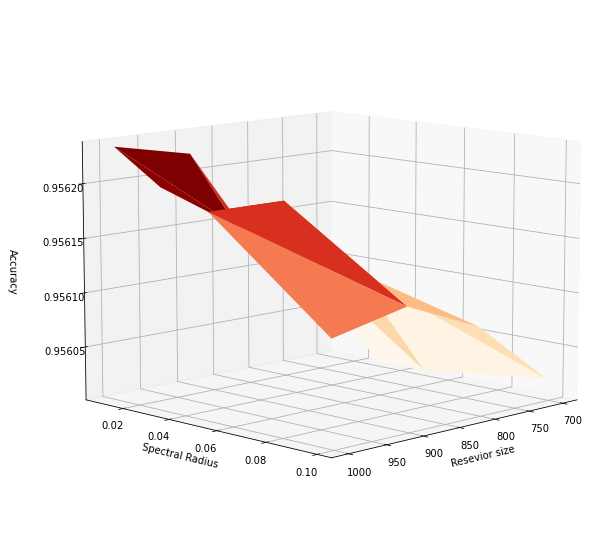

In [ ]:
# df = pd.read_csv(esn_config['result_loc'] + 'accuracies.csv',names=['x','y','z'])
# fig = plt.figure(figsize=(10,10))
# #    fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(df['x'].values, df['y'].values,
#                  df['z'].values, cmap=cm.OrRd, linewidth=0.5)
# ax.azim = 45
# ax.elev = 10
# ax.set_xlabel('Resevior size')
# ax.set_ylabel('Spectral Radius')
# #    plt.zticks(rotaion=60)
# ax.set_zlabel('Accuracy',labelpad=20)

## Image Segmentation using an SVM classifier
Fit an ESN model with SVM readout to the tensor-based dataset and test the accuracy of the model. 

In [ ]:
# # unlike ESN Y_train starts from the first value                
# Y_train = data[0 :train_len, -1]  
# # create an svm classification model
# svm_model = svm.SVC(kernel='rbf', C=1.0, gamma=1000) 
# # train the svm model
# svm_model.fit(X_train, Y_train)
# # test the model on unseen dataset
# Yhat = svm_model.predict(X_test)
# Y_test = np.squeeze(np.asarray(Y_test.T))
# print(f'SVM accuracy score: {accuracy_score(Y_test,Yhat)}')